In [23]:
from __future__ import annotations
import zipfile
import pandas as pd
import os
from io import StringIO
import matplotlib.pyplot as plt
import tempfile
import plotly.express as px
import numpy as np

In [3]:
import sys
sys.path.append('/Users/alex/Desktop/CS/Internships/DBF/Alex_DBF/python_tools')
from util.blackbox import decode_blackbox

In [4]:
MAIN_DIR = '/Users/alex/Desktop/CS/Internships/DBF/Alex_DBF/python_tools/data/year2/12-06-2024'
BLACKBOX_ZIP = MAIN_DIR + '/INAV Data.zip'
TORQUE_ZIP = MAIN_DIR + '/CoolTerm Data.zip'
OUTPUT_DIR = MAIN_DIR + '/output'

In [30]:
MIN_THROTTLE = 1000
MAX_THROTTLE = 2011

In [ ]:
blackbox_dfs: dict[str, pd.DataFrame] = {}

with zipfile.ZipFile(BLACKBOX_ZIP) as z:
    for name in filter(lambda x: x.endswith(".TXT") and not x.startswith('__MACOSX'), z.namelist()):
        with tempfile.TemporaryDirectory() as tmpdirname:
            z.extract(name, tmpdirname)
            df = decode_blackbox(tmpdirname + "/" + name)

        name = name.replace(".TXT", "").split("/")[-1]
        parts = name.split("_")
                
        df.dropna(inplace=True, subset=['motor[0]'])
        df.rename(columns={"motor[0]": "throttle"}, inplace=True)
        df["motor"] = parts[0]
        df["prop"] = parts[1]
        df["something"] = parts[-1]
        blackbox_dfs[name.lower()] = df

In [7]:
blackbox_dfs.keys()

dict_keys(['at7215_18x12_moi_base', 'at7215_18x12_moi_puck1.3', 'at7215_18x12_moi_puck1'])

In [15]:
blackbox_dfs = {k.replace('18x12', '18x10'): v for k, v in blackbox_dfs.items()}

In [16]:
torque_dfs: dict[str, pd.DataFrame] = {}

with zipfile.ZipFile(TORQUE_ZIP) as z:
    for name in filter(lambda x: x.endswith(".txt") and not x.startswith('__MACOSX'), z.namelist()):
        data = z.read(name)
        # remove lines without a comma
        data = b"\n".join(filter(lambda x: b"," in x, data.split(b"\n")))
        number_of_columns = len(data.split(b'\n')[0].split(b','))
        columns = [f'col_{i}' for i in range(number_of_columns)]
        columns[0] = 'loop_iteration'
        columns[1] = 'thrust'
        columns[2] = 'torque'
        columns[3] = 'voltage'
        columns[4] = 'current'
        df = pd.read_csv(StringIO(data.decode('utf-8')), sep=",", header=None, names=columns)
        df = df[['loop_iteration', 'torque']]
        if df.iloc[0]['loop_iteration'] > 800_000:
            # remove the first row
            df = df.iloc[1:]
        torque_dfs[name.replace(".txt","").split("/")[-1].lower()] = df

torque_dfs.keys()

dict_keys(['at7215_18x10_moi_puck1', 'at7215_18x10_moi_puck1.3', 'at7215_18x10_moi_base'])

In [17]:
# find non common df names
torque_only_dfs = set(torque_dfs.keys()).difference(set(blackbox_dfs.keys()))
print('Torque but not blackbox:', torque_only_dfs)

blackbox_only_dfs = set(blackbox_dfs.keys()).difference(set(torque_dfs.keys()))
print('Blackbox but not torque:', blackbox_only_dfs)

Torque but not blackbox: set()
Blackbox but not torque: set()


In [18]:
# find common df names
common_dfs = set(blackbox_dfs.keys()).intersection(set(torque_dfs.keys()))
print(common_dfs)

{'at7215_18x10_moi_puck1', 'at7215_18x10_moi_base', 'at7215_18x10_moi_puck1.3'}


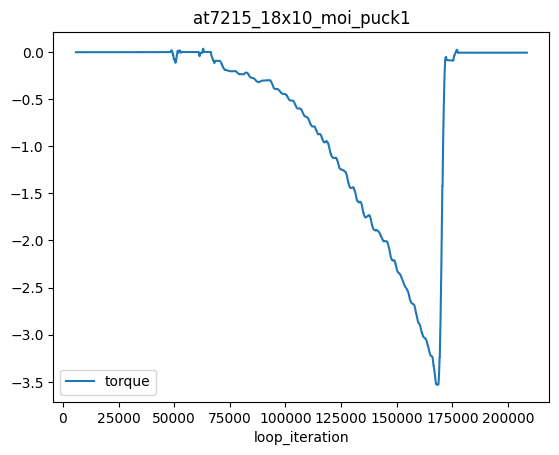

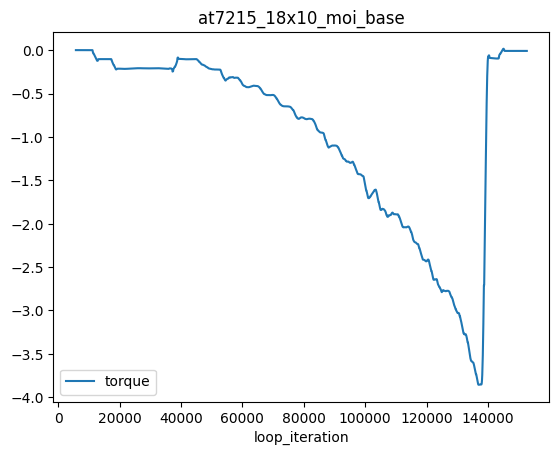

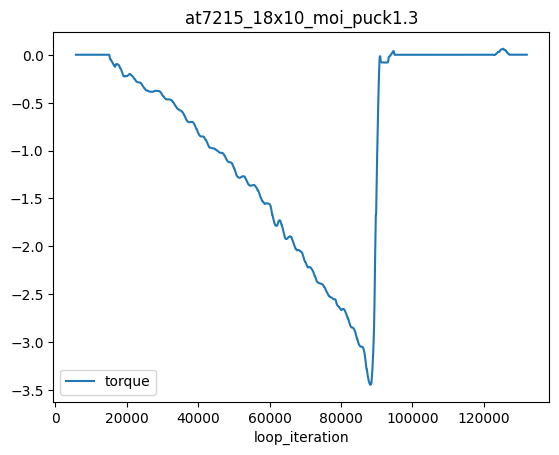

In [19]:
for key in common_dfs:
    torque_dfs[key].plot(x='loop_iteration', y='torque', title=key)

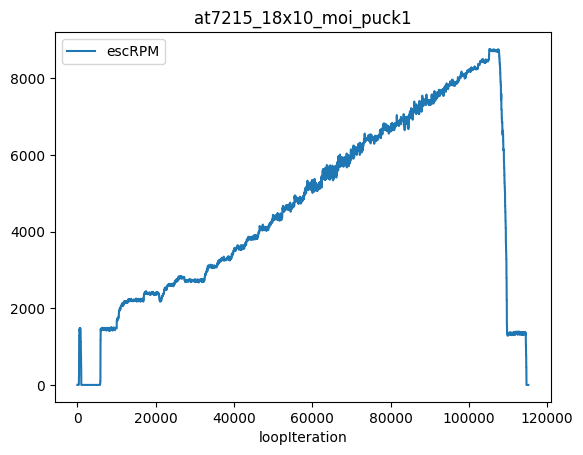

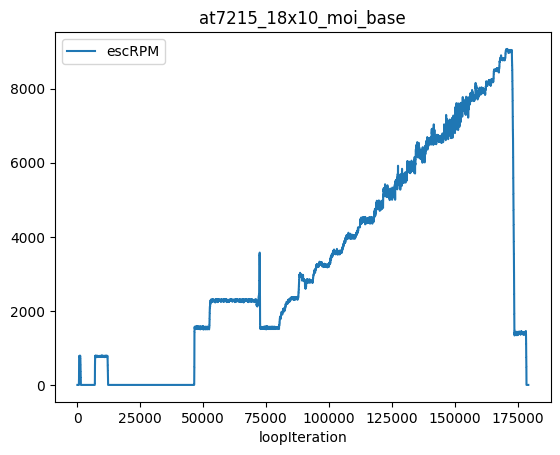

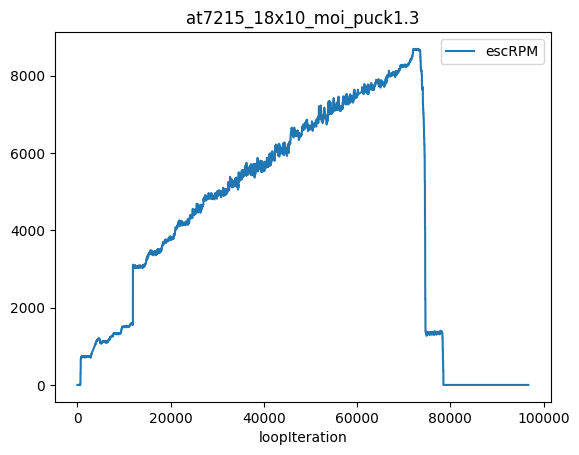

In [20]:
for key in common_dfs:
    blackbox_dfs[key].plot(x='loopIteration', y='escRPM', title=key)

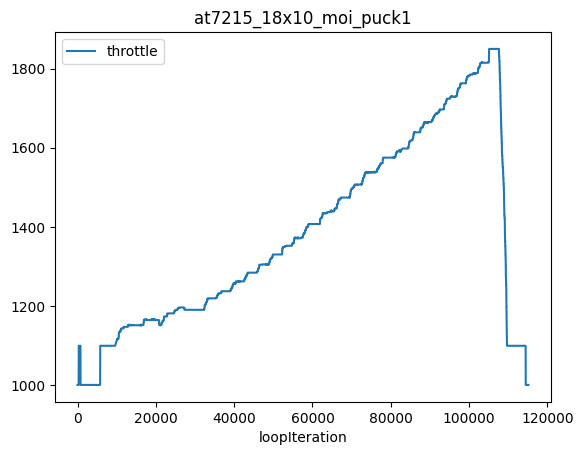

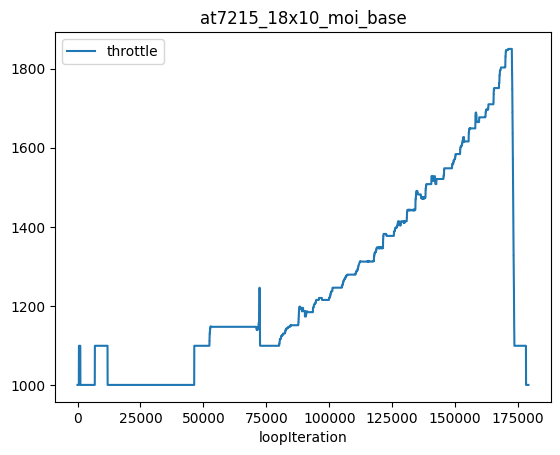

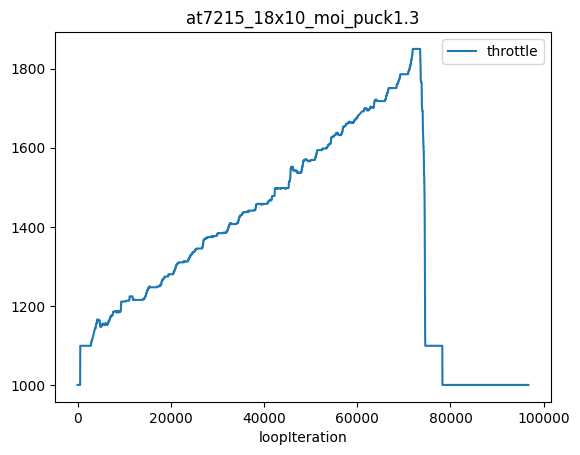

In [21]:
for key in common_dfs:
    blackbox_dfs[key].plot(x='loopIteration', y='throttle', title=key)

at7215_18x10_moi_puck1
at7215_18x10_moi_base
at7215_18x10_moi_puck1.3


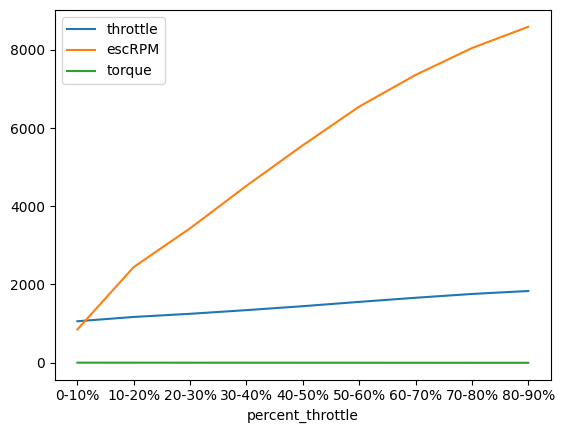

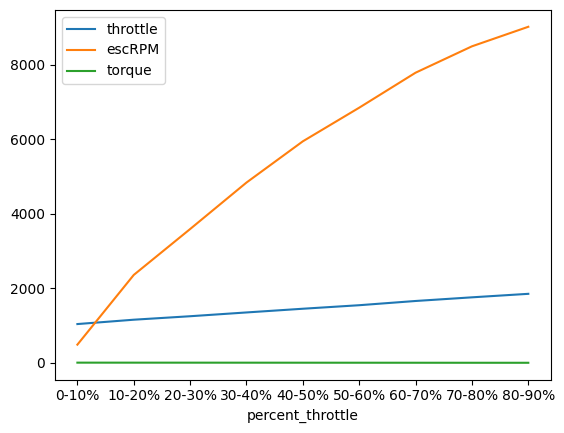

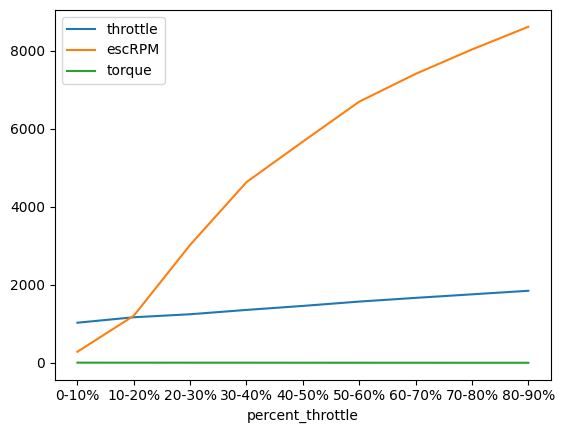

In [32]:
BLACKBOX_COLS = ['throttle', 'escRPM']
TORQUE_COLS = ['torque']
METADATA = ['motor', 'prop', 'something']

for name in list(common_dfs):
    print(name)

    metadata = dict(zip(METADATA, name.split("_")))

    df = blackbox_dfs[name][['loopIteration'] + BLACKBOX_COLS].copy()
    peak_rpm = blackbox_dfs[name]['loopIteration'][blackbox_dfs[name]['escRPM'].idxmax()]
    df['loopIteration'] -= peak_rpm

    df_torque = torque_dfs[name][['loop_iteration'] + TORQUE_COLS].copy()
    df_torque['loop_iteration'] = df_torque['loop_iteration'].astype(np.int64)
    peak_torque = df_torque['loop_iteration'][df_torque['torque'].sub(df_torque['torque'].mean()).abs().idxmax()]
    df_torque['loop_iteration'] -= peak_torque
    
    df = pd.merge_asof(df, df_torque, left_on='loopIteration', right_on='loop_iteration', direction='nearest')

    df["percent_throttle"] = (df["throttle"] - MIN_THROTTLE) / (MAX_THROTTLE - MIN_THROTTLE) * 100
    # bin by percent_throttle ranges [0, 10), [10, 20), ..., [90, 100]
    df["percent_throttle"] = df["percent_throttle"].apply(lambda x: int(x // 10) * 10)
    df = df.groupby('percent_throttle').mean().reset_index()
    # change percent_throttle to indicate the range
    df["percent_throttle"] = df["percent_throttle"].apply(lambda x: f"{x}-{x+10}%") 

    for col in METADATA:
        df[col] = metadata[col]

    df[['percent_throttle'] + BLACKBOX_COLS + TORQUE_COLS + METADATA].to_csv(OUTPUT_DIR + "/" + name + ".csv", index=False)
    df[['percent_throttle'] + BLACKBOX_COLS + TORQUE_COLS + METADATA].plot(x='percent_throttle')
    plt.savefig(OUTPUT_DIR + "/" + name + ".png")